# Retinal Disease Detection and Classification

## By: Jalen Wu, Yechan Na, Jonathan Zhang

__Project Description:__

The goal of this project is to develop a machine learning model capable of detecting retinal diseases by analyzing fundus images of the eye. Using computer vision and deep learning techniques, the model assists in early detection and diagnosis of retinal disease(s).

__Applications and Impact:__

This project could be used for clinical screening to help ophthalmologists identify diseases and improve efficiency on identifying these diseases. This automated detection system has the potential to make medical imaging diagnostics more accessible.

__What we hope to achieve:__

We hope to build a model that takes in images of the eye and accurately predicts whether an individual’s eyes are healthy or showing signs of disease. To quantify the effectiveness of our model, we will be measuring metrics such as F1 score, precision, recall, loss, and accuracy of our models and graphing them as a function of how many epochs we run on our training data (all of these scores should increase in subsequent epochs).

- __Dataset__: https://www.kaggle.com/datasets/andrewmvd/retinal-disease-classification/data
- __References__: 
    - https://www.mdpi.com/2306-5729/6/2/14
    - https://jamanetwork.com/journals/jama/fullarticle/2588763
    

In [ ]:
# imports

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import os
from torch.utils.data import Dataset
import pandas as pd
from skimage import io, transform
from torch import tensor
from PIL import Image
from torch import flatten
from nltk.metrics.scores import (precision, recall, f_measure, accuracy)
from tqdm import tqdm

Importing Retinal Disease dataset from Kaggle

In [41]:
# Import Dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/retinal-disease-classification")

print("Path to dataset files:", path)

Path to dataset files: /Users/jalenwu/.cache/kagglehub/datasets/andrewmvd/retinal-disease-classification/versions/1


Setting the device to run our model

In [42]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


Defining a Transform function to be applied to all images in our dataset and verifying success of dataset download.

In [ ]:
# X = 1424 x 2144 x 3 : h x w x colors
# y = label
transform = transforms.Compose([
    transforms.Resize((int(1424 / 8), int(2144 / 8))), # Standardize image dimensions
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

base_directory = path  
print(base_directory)

if os.path.exists(base_directory):
    print("Directory exists and its contents are:")
    print(os.listdir(base_directory))
else:
    print("Directory does not exist.")

/Users/jalenwu/.cache/kagglehub/datasets/andrewmvd/retinal-disease-classification/versions/1
Directory exists and its contents are:
['.DS_Store', 'Evaluation_Set', 'Training_Set', 'Test_Set']


Defining constants for a single point of control

In [44]:
# Constants (paths that will be accessed later in the project)
BASE_DIRECTORY = path
TRAINING_DIRECTORY = os.path.join(BASE_DIRECTORY, 'Training_Set', 'Training_Set', 'Training')
TRAINING_LABELS = os.path.join(BASE_DIRECTORY, 'Training_Set', 'Training_Set', 'RFMiD_Training_Labels.csv')
TESTING_DIRECTORY = os.path.join(BASE_DIRECTORY, 'Test_Set', 'Test_Set', 'Test')
TESTING_LABELS = os.path.join(BASE_DIRECTORY, 'Test_Set', 'Test_Set', 'RFMiD_Testing_Labels.csv')

Initialized training and testing labels for images in Pandas DataFrames to add support for data manipulation

In [45]:
# Delegated the dataframe creation outside of the dataset class
training_labels_df = pd.read_csv(TRAINING_LABELS)
testing_labels_df = pd.read_csv(TESTING_LABELS)

In [48]:
training_labels_df.head()

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
training_labels_df = training_labels_df.filter(['Disease_Risk'])
testing_labels_df = testing_labels_df.filter(['Disease_Risk'])

,Disease_Risk
0,1
1,1
2,1
3,1
4,1


Created a custom Dataset class that extends the abstract Dataset class provided by PyTorch. 
- This step was necessary as the built-in Dataset classes offered by PyTorch were not compatible with the local file structure of our dataset.

In [50]:
class MultiClassDataset(Dataset):
    """
    Supports structure of given dataset (images in child folder and labels in csv format).
    """
    def __init__(self, label_csv_file, image_directory, transform=None):
        """
        Args:
            label_csv_file (DataFrame): Dataframe of the CSV label file.
            image_directory (str): Directory with eye images.
            transform (callable, optional): transform function to be applied to each image.
        """
        self.label_csv_file = label_csv_file
        self.image_directory = image_directory
        self.transform = transform
    
    def __len__(self):
        return len(self.label_csv_file)    

    def __getitem__(self, index):
        """
        Args:
            index: the index of the image/label pair we want to retrieve
            
        Returns:
            image_and_label (dict): A dictionary containing the image and its corresponding label at the requested index.
        """

        # The images are PNG and one-indexed (1.png, 2.png, 3.png, ...)
        image_path = os.path.join(self.image_directory, str(index + 1) +'.png')
        
        image_label = self.label_csv_file.loc[index]
        image_label = image_label.to_numpy()
        image_label = tensor(image_label)
        
        # Loads image at the given path.
        current_image = io.imread(image_path)
        
        if current_image is None or current_image.size == 0:
            raise ValueError(f"Failed to load image: {image_path}")
       
        # Convert to PIL Image
        current_image = Image.fromarray(current_image)
        
        # If transform function passed in, apply transform to image
        if self.transform:
            transformed_image = self.transform(current_image)
            return {'image': transformed_image, 'label': image_label}
        
        return {'image': current_image,'label': image_label}

Initialized Training dataset and loader for later use in a neural network

In [51]:
# Initializing dataset and loader.
train_dataset = MultiClassDataset(label_csv_file=training_labels_df, image_directory=TRAINING_DIRECTORY, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64)

# Visualize loader
res = next(iter(train_loader))


Verifying correct initialization of items contained in data loader

In [52]:
print(res['image'].shape)
print(res['label'].shape)

print(res['label'][0])
print(res['label'][1])
print(res['label'][2])
print(res['label'][3])
print(res['image'][0][0])

torch.Size([64, 3, 178, 268])
torch.Size([64, 1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [53]:
# image tensor format: [batch_size, channels, height, width]
print(res['image'][0].shape)

torch.Size([3, 178, 268])


Construction of our Convolutional Neural Network
- 3 groupings of convolutional layer, ReLU activation layer, and pooling layer.
- Flattening to transfer data to fully connected layers.
- 4 fully connected layers, each followed by a ReLU activation layer.
- 1 output layer, utilizing sigmoid activation to classify the output of the network.

The forward function is called every time a set of data is passed through the network.

In [54]:
# Original Network
class Conv_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(8640, 256)
        self.fc2 = nn.Linear(256, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 23)
        self.fc5 = nn.Linear(23, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.sigmoid(self.fc5(x))
        return x

conv_model = Conv_NN()

Definition of our training function

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    """
    Trains the model for one epoch.
    
    Args:
        dataloader (DataLoader): DataLoader object with training data
        model (nn.Module): Model to be trained
        loss_fn (nn.Module): Loss function to be used
        optimizer (torch.optim): Optimizer to be used
    
    Returns:
        float: Average loss for the current epoch
    """
    model.train()
    size = len(dataloader.dataset)
    total_loss = 0.0
    
    for i, data in tqdm(enumerate(dataloader)):
        # get the inputs; data is a dict of [inputs, labels]
        inputs = data['image']
        labels = data['label']
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_fn(outputs, labels.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()

        # print statistics
        total_loss += loss.item()
    
    return total_loss/size

Creation of test dataset and loader for testing data

In [56]:
test_dataset = MultiClassDataset(label_csv_file=testing_labels_df, image_directory=TESTING_DIRECTORY, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64)

Helper function to determine precision, recall, f1, and accuracy metrics when given a list of predictions and a list of true values (common measures of model effectiveness)

In [ ]:
def PRFA(predictions, answers):
    """
    Returns precision, recall, f1, and accuracy of the predictions.
    
    Args:
        predictions (list): List of predicted labels
        answers (list): List of actual labels
    """
    pred_indices = [x for x in range(len(predictions)) if predictions[x] == 1]
    actual_indices = [y for y in range(len(answers)) if answers[y] == 1]

    temp_precision = precision(set(pred_indices), set(actual_indices)) # actual labels vs. predicted labels
    temp_recall = recall(set(pred_indices), set(actual_indices))
    temp_f1 = f_measure(set(pred_indices), set(actual_indices))
    temp_accuracy = accuracy(answers, predictions)
    return (temp_precision, temp_recall, temp_f1, temp_accuracy)


In [ ]:
accuracy_values = []

def get_preds(dataloader, model):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader)):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data['image']
            l = data['label']
            
            labels.append(l)
            preds.append(model(inputs))
    return torch.cat(preds), torch.cat(labels)


def get_clamped_preds(preds, t):
    """
    Takes a dataloader for the test data and model
    Returns the Precision, Recall, F1 Score, and Accuracy of the model as a tuple
    """
    
    new_preds = torch.tensor(np.zeros([len(preds)], dtype=int))
    
    # Goes through all images in preds
    for img_in_batch in range(len(preds)): 
        # Goes through all disease labels in the image
        # Clamp the values to 0 or 1
        if preds[img_in_batch] > t:
            new_preds[img_in_batch] = 1
        else:
            new_preds[img_in_batch] = 0
    return new_preds


def test(new_preds, labels):
    size = len(new_preds)
    correct = 0
    for i in range(len(new_preds)):
        if new_preds[i] == labels[i]:
            correct += 1

    accuracy = correct / size
    print("Accuracy: ", accuracy)
    return PRFA(new_preds, labels)

Optimizer: Stochastic Gradient Descent with Momentum
- learning rate set to 0.001 
- momentum (beta) set to 0.9

$$
w_{t+1} = w_t - V_t
$$

$$
V_t = V_{t-1} + (1 - \beta) \frac{\partial L}{\partial w_t} 
$$


In [ ]:
import torch.optim as optim

loss_fn = nn.BCELoss()

# Changed learning rate from 0.001 to 0.01
optimizer = optim.SGD(conv_model.parameters(), lr=0.001, momentum=0.9)

Training the Neural Network
- Maximum number of epochs: 40
- Each epoch runs train, then test
- PRFA scores are saved and written to .txt file for later use or reference

In [ ]:
epochs = 40
conv_model_loss = []
p_scores = []
r_scores = []
f_scores = []
a_scores = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    conv_loss = train(train_loader, conv_model, loss_fn, optimizer)
    print("Convolutional Model Loss: ", conv_loss)
    
    # Early stop if loss has increased.
    if t > 3 and conv_loss > conv_model_loss[-1]:
        break
        
    preds, labels = get_preds(test_loader, conv_model)
    avg = (max(preds) + min(preds)) / 2
    new_preds = get_clamped_preds(torch.flatten(preds), avg)
    p, r, f, a = test(new_preds, labels)
    
    print("prfa: ")
    print(p, r, f, a)
    p_scores.append(p)
    r_scores.append(r)
    f_scores.append(f)
    a_scores.append(a)
    
    conv_model_loss.append(conv_loss)
    torch.save(conv_model.state_dict(), "binary_model.pth")
    file = open("Convolutional_model_scores.txt", "w", encoding="utf8")
    file.write(f"losses: {conv_model_loss} \n")
    file.write(f"precisions: {p_scores} \n")
    file.write(f"recalls: {r_scores} \n")
    file.write(f"f1 scores: {f_scores} \n")
    file.write(f"accuracies: {a_scores} \n")
    file.close()

Epoch 1
-------------------------------


30it [05:47, 11.59s/it]


Convolutional Model Loss:  0.011058783996850252


10it [01:55, 11.50s/it]


Accuracy:  0.309375
prfa: 
0.12648221343873517 1.0 0.22456140350877193 tensor([0.3094])
Epoch 2
-------------------------------


30it [05:51, 11.72s/it]


Convolutional Model Loss:  0.010581581170360248


10it [01:56, 11.64s/it]


Accuracy:  0.3765625
prfa: 
0.21541501976284586 0.9819819819819819 0.35332252836304695 tensor([0.3766])
Epoch 3
-------------------------------


30it [07:41, 15.39s/it]


Convolutional Model Loss:  0.010157201625406741


10it [02:30, 15.03s/it]


Accuracy:  0.4078125
prfa: 
0.25889328063241107 0.9703703703703703 0.40873634945397813 tensor([0.4078])
Epoch 4
-------------------------------


30it [09:28, 18.96s/it]


Convolutional Model Loss:  0.009806633461266756


10it [02:02, 12.27s/it]


Accuracy:  0.4
prfa: 
0.2509881422924901 0.9621212121212122 0.3981191222570533 tensor([0.4000])
Epoch 5
-------------------------------


30it [05:40, 11.35s/it]


Convolutional Model Loss:  0.00951043733706077


10it [01:53, 11.39s/it]


Accuracy:  0.4359375
prfa: 
0.30434782608695654 0.9447852760736196 0.46038863976083705 tensor([0.4359])
Epoch 6
-------------------------------


30it [05:41, 11.37s/it]


Convolutional Model Loss:  0.009257810718069474


10it [02:12, 13.28s/it]


Accuracy:  0.4125
prfa: 
0.2727272727272727 0.9452054794520548 0.42331288343558277 tensor([0.4125])
Epoch 7
-------------------------------


30it [06:01, 12.04s/it]


Convolutional Model Loss:  0.00904250293970108


10it [01:59, 11.90s/it]


Accuracy:  0.3875
prfa: 
0.24110671936758893 0.9384615384615385 0.3836477987421384 tensor([0.3875])
Epoch 8
-------------------------------


30it [05:36, 11.23s/it]


Convolutional Model Loss:  0.008856751226509611


10it [02:01, 12.16s/it]


Accuracy:  0.315625
prfa: 
0.1383399209486166 0.9722222222222222 0.24221453287197228 tensor([0.3156])
Epoch 9
-------------------------------


30it [05:53, 11.77s/it]


Convolutional Model Loss:  0.008695403983195623


10it [01:55, 11.51s/it]


Accuracy:  0.2984375
prfa: 
0.116600790513834 0.9672131147540983 0.20811287477954143 tensor([0.2984])
Epoch 10
-------------------------------


30it [05:39, 11.31s/it]


Convolutional Model Loss:  0.008550565581147869


10it [01:54, 11.41s/it]


Accuracy:  0.3125
prfa: 
0.13438735177865613 0.9714285714285714 0.2361111111111111 tensor([0.3125])
Epoch 11
-------------------------------


30it [05:47, 11.60s/it]


Convolutional Model Loss:  0.008413354633376002


10it [02:05, 12.59s/it]


Accuracy:  0.3578125
prfa: 
0.1956521739130435 0.9611650485436893 0.3251231527093596 tensor([0.3578])
Epoch 12
-------------------------------


30it [06:06, 12.23s/it]


Convolutional Model Loss:  0.008279450656846165


10it [01:54, 11.46s/it]


Accuracy:  0.4015625
prfa: 
0.25889328063241107 0.9424460431654677 0.40620155038759687 tensor([0.4016])
Epoch 13
-------------------------------


30it [06:01, 12.05s/it]


Convolutional Model Loss:  0.008156304030368726


10it [02:04, 12.41s/it]


Accuracy:  0.4203125
prfa: 
0.2865612648221344 0.9354838709677419 0.43872919818456885 tensor([0.4203])
Epoch 14
-------------------------------


30it [06:01, 12.04s/it]


Convolutional Model Loss:  0.008060840998465817


10it [02:02, 12.22s/it]


Accuracy:  0.4359375
prfa: 
0.3102766798418972 0.9289940828402367 0.46518518518518515 tensor([0.4359])
Epoch 15
-------------------------------


30it [06:33, 13.10s/it]


Convolutional Model Loss:  0.008001403541614611


10it [02:03, 12.30s/it]


Accuracy:  0.4484375
prfa: 
0.3300395256916996 0.9226519337016574 0.48617176128093154 tensor([0.4484])
Epoch 16
-------------------------------


30it [07:39, 15.33s/it]


Convolutional Model Loss:  0.007970909013723333


10it [02:06, 12.69s/it]


Accuracy:  0.453125
prfa: 
0.3359683794466403 0.9239130434782609 0.4927536231884058 tensor([0.4531])
Epoch 17
-------------------------------


30it [06:30, 13.03s/it]


Convolutional Model Loss:  0.007959731590623657


10it [02:29, 14.99s/it]


Accuracy:  0.4484375
prfa: 
0.3221343873517787 0.9421965317919075 0.48011782032400596 tensor([0.4484])
Epoch 18
-------------------------------


30it [07:44, 15.48s/it]


Convolutional Model Loss:  0.007956184741730491


10it [01:49, 10.94s/it]


Accuracy:  0.4421875
prfa: 
0.3142292490118577 0.9408284023668639 0.4711111111111111 tensor([0.4422])
Epoch 19
-------------------------------


30it [05:36, 11.22s/it]


Convolutional Model Loss:  0.007953492101902764


10it [02:14, 13.41s/it]


Accuracy:  0.440625
prfa: 
0.308300395256917 0.9512195121951219 0.4656716417910448 tensor([0.4406])
Epoch 20
-------------------------------


30it [06:01, 12.04s/it]


Convolutional Model Loss:  0.007950710598379374


10it [01:57, 11.77s/it]


Accuracy:  0.4390625
prfa: 
0.30632411067193677 0.950920245398773 0.46337817638266066 tensor([0.4391])
Epoch 21
-------------------------------


30it [05:55, 11.86s/it]


Convolutional Model Loss:  0.007947629659126203


10it [02:00, 12.07s/it]


Accuracy:  0.4375
prfa: 
0.30434782608695654 0.9506172839506173 0.4610778443113773 tensor([0.4375])
Epoch 22
-------------------------------


30it [05:53, 11.79s/it]


Convolutional Model Loss:  0.007944561339293917


10it [02:01, 12.13s/it]


Accuracy:  0.4375
prfa: 
0.30434782608695654 0.9506172839506173 0.4610778443113773 tensor([0.4375])
Epoch 23
-------------------------------


30it [06:30, 13.00s/it]


Convolutional Model Loss:  0.007941585732623935


10it [02:02, 12.23s/it]


Accuracy:  0.4375
prfa: 
0.30434782608695654 0.9506172839506173 0.4610778443113773 tensor([0.4375])
Epoch 24
-------------------------------


30it [05:59, 11.97s/it]


Convolutional Model Loss:  0.007938480641071995


10it [02:11, 13.15s/it]


Accuracy:  0.4359375
prfa: 
0.30237154150197626 0.9503105590062112 0.4587706146926536 tensor([0.4359])
Epoch 25
-------------------------------


30it [06:45, 13.53s/it]


Convolutional Model Loss:  0.007935411995276809


10it [01:51, 11.15s/it]


Accuracy:  0.434375
prfa: 
0.2984189723320158 0.9556962025316456 0.45481927710843373 tensor([0.4344])
Epoch 26
-------------------------------


30it [06:11, 12.37s/it]


Convolutional Model Loss:  0.007932313081497947


10it [01:59, 11.96s/it]


Accuracy:  0.434375
prfa: 
0.2964426877470356 0.9615384615384616 0.45317220543806647 tensor([0.4344])
Epoch 27
-------------------------------


30it [19:47, 39.57s/it] 


Convolutional Model Loss:  0.007929161237552763


10it [01:52, 11.25s/it]


Accuracy:  0.4296875
prfa: 
0.29051383399209485 0.9607843137254902 0.4461305007587253 tensor([0.4297])
Epoch 28
-------------------------------


30it [06:22, 12.75s/it]


Convolutional Model Loss:  0.007925776314611237


10it [01:53, 11.38s/it]


Accuracy:  0.43125
prfa: 
0.29051383399209485 0.9671052631578947 0.44680851063829785 tensor([0.4313])
Epoch 29
-------------------------------


30it [06:00, 12.01s/it]


Convolutional Model Loss:  0.007922232119987408


10it [01:50, 11.04s/it]


Accuracy:  0.4328125
prfa: 
0.2885375494071146 0.9798657718120806 0.44580152671755724 tensor([0.4328])
Epoch 30
-------------------------------


30it [06:04, 12.15s/it]


Convolutional Model Loss:  0.007918744099636872


10it [01:53, 11.35s/it]


Accuracy:  0.43125
prfa: 
0.2865612648221344 0.9797297297297297 0.44342507645259943 tensor([0.4313])
Epoch 31
-------------------------------


27it [06:51, 15.25s/it]


KeyboardInterrupt: 

In [24]:
conv_model = Conv_NN()
conv_model.load_state_dict(torch.load("binary_model.pth", weights_only=True))

preds, labels = get_preds(test_loader, conv_model)
avg = (max(preds) + min(preds)) / 2
print(avg)
new_preds = get_clamped_preds(torch.flatten(preds), avg)
print(new_preds[0])
print(new_preds[1])
print(new_preds[2])

10it [02:05, 12.51s/it]

tensor([0.6546])
tensor(1)
tensor(1)
tensor(1)


Printing predicted images from testing
- Correct Prediction + Label
- Incorrect Prediction + Label

In [136]:
# Gathers indices of images that were correctly predicted (matches) and incorrectly predicted (mismatches).

mismatches = []
matches = []
healthy_matches = []
for img in range(len(new_preds)):
    if new_preds[img] != labels[img]:
        mismatches.append(img)
    elif new_preds[img] == 0:
        healthy_matches.append(img)
    else:
        matches.append(img)

print(mismatches[:10])
print(matches[:10])
print(healthy_matches[:10])

[5, 6, 7, 8, 12, 13, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 9, 10, 11, 14, 15]
[244, 271, 272, 275, 276, 277, 278, 279, 280, 290]


In [77]:
test_imgs = []
test_lbls = []
with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data['image']
        l = data['label']
        test_imgs.append(inputs)
        test_lbls.append(l)

10it [02:11, 13.15s/it]


In [143]:
244 / 64
# test_imgs[][51]

3.8125

In [ ]:
# 64 * 3
# 0 1
# 1 65
# 2 129
# 3 193
# 4 257

192

In [141]:
# Batch, Image
# Batch, Image, Channel, Height, Width
print(test_lbls[0].shape)
print(test_imgs[0].shape)
print(len(test_imgs))
print(len(new_preds))
print(new_preds[0])

print(test_lbls)


torch.Size([64, 1])
torch.Size([64, 3, 178, 268])
10
640
tensor(1)
[tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]]), tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
       

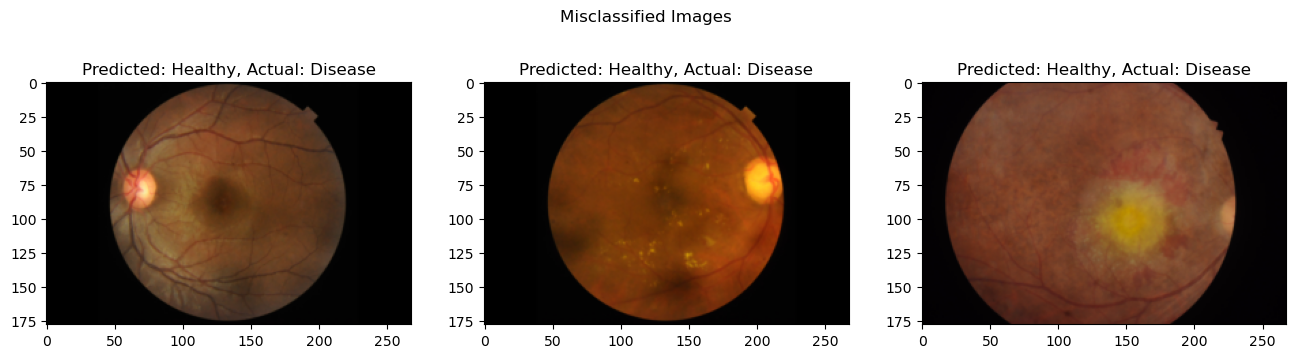

In [134]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
readable = {0: "Healthy", 1: "Disease"}

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,4))

fig.suptitle("Misclassified Images")
ax1.imshow(test_imgs[mismatches[0]][0].numpy().transpose(1, 2, 0))
ax1.set_title(f"Predicted: {readable[int(new_preds[mismatches[0]])]}, Actual: {readable[int(labels[mismatches[0]][0])]}")

ax2.imshow(test_imgs[mismatches[1]][0].numpy().transpose(1, 2, 0))
ax2.set_title(f"Predicted: {readable[int(new_preds[mismatches[1]])]}, Actual: {readable[int(labels[mismatches[1]][0])]}")

ax3.imshow(test_imgs[mismatches[2]][0].numpy().transpose(1, 2, 0))
ax3.set_title(f"Predicted: {readable[int(new_preds[mismatches[2]])]}, Actual: {readable[int(labels[mismatches[2]][0])]}")

plt.show()

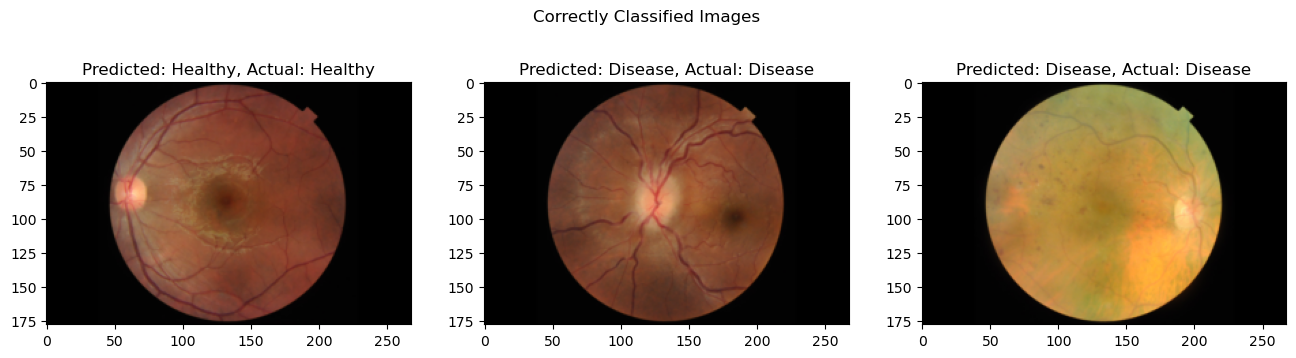

In [150]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,4))

fig.suptitle("Correctly Classified Images")
ax3.imshow(test_imgs[matches[0]][0].numpy().transpose(1, 2, 0))
ax3.set_title(f"Predicted: {readable[int(new_preds[matches[0]])]}, Actual: {readable[int(labels[matches[0]][0])]}")
ax2.imshow(test_imgs[matches[1]][0].numpy().transpose(1, 2, 0))
ax2.set_title(f"Predicted: {readable[int(new_preds[matches[1]])]}, Actual: {readable[int(labels[matches[1]][0])]}")
ax1.imshow(test_imgs[3][52].numpy().transpose(1, 2, 0))
ax1.set_title(f"Predicted: {readable[int(new_preds[healthy_matches[0]])]}, Actual: {readable[int(labels[healthy_matches[0]][0])]}")
plt.show()

# Analysis
- Plot loss/accuracy (y) with number of epochs ran (x)
- Recall/Precision/F1 score 

In [62]:
def graph_loss(x, y, metric):

    plt.plot(x, y)
    plt.xlabel("epoch #")
    plt.ylabel(f"{metric} score per epoch")
    plt.title(f"{metric} Scores")
    plt.savefig(f"{metric}_plot.png")
    plt.clf()

graph_loss(range(len(conv_model_loss)), conv_model_loss, "Cross Entropy Loss")
graph_loss(range(len(p_scores)), p_scores, "Precision")
graph_loss(range(len(r_scores)), r_scores, "Recall")
graph_loss(range(len(f_scores)), f_scores, "F1")
graph_loss(range(len(a_scores)), a_scores, "Accuracy")

<Figure size 640x480 with 0 Axes>

In [63]:
print("First vs Final Scores:")
print("Cross Entropy Loss:", conv_model_loss[0], conv_model_loss[-1])
print("Precision:", p_scores[0], p_scores[-1])
print("Recall:", r_scores[0], r_scores[-1])
print("F1:", f_scores[0], f_scores[-1])
print("Accuracy:", float(a_scores[0]), float(a_scores[-1]))

First vs Final Scores:
Cross Entropy Loss: 0.011058783996850252 0.007918744099636872
Precision: 0.12648221343873517 0.2865612648221344
Recall: 1.0 0.9797297297297297
F1: 0.22456140350877193 0.44342507645259943
Accuracy: 0.30937498807907104 0.4312500059604645
